In [ ]:
# Chase Abram
# IO 2 2021 with Hortacsu

In [239]:
using CSV
using DataFrames
using ForwardDiff
using LinearAlgebra
using Optim

using Random, Distributions
using Statistics
# using Pkg
# Pkg.add("StatsPlots")
using StatsPlots

using Plots

In [290]:
# Section 1.3

# Compute the implied best-response probabilities
function BR_p(p, x, alpha, delta)
    if length(p) == 2
        return exp.(alpha .* x .- delta .* reverse(p) .- maximum(alpha .* x .- delta .* reverse(p)))./(exp(-maximum(alpha .* x .- delta .* reverse(p))) .+ exp.(alpha .*x .- delta .* reverse(p) .- maximum(alpha .* x .- delta .* reverse(p))))
    else
        return exp.(alpha .* x .- delta .* p .- maximum(alpha .* x .- delta .* p))./(exp(-maximum(alpha .* x .- delta .* p)) .+ exp.(alpha .*x .- delta .* p .- maximum(alpha .* x .- delta .* p)))
    end
end

# Jacobian of BR wrt p
function BR_p_jac(p, x, alpha, delta)
    if length(p) == 2
        return [0 -delta*exp.(alpha .* x .- delta .* p[2])./((1 .+ exp.(alpha .*x .- delta .* p[2]))^2);
            -delta*exp.(alpha .* x .- delta .* p[1])./((1 .+ exp.(alpha .*x .- delta .* p[1]))^2) 0]
    else
        return -delta*exp.(alpha .* x .- delta .* p[1])./((1 .+ exp.(alpha .*x .- delta .* p[1]))^2)
    end
end

# br_test(z) = BR_p(z, 2, 3, 6)

# println("BRj: ", BR_p_jac([0.7, 0.6], 2, 3, 6))
# println("AD: ", ForwardDiff.jacobian(br_test, [0.7, 0.6]))

# Finds local FP by Newton-Kantorovich
function fp_logit_nk(x, alpha, delta, p_init = [0.5], maxiter = 1000, tol = 1e-14)
    
    # Fix parameters
#     f(z) = BR_p(z,x,alpha,delta) - z
    
    # Initialize
    it = 0
    diff = Inf
    
    p = p_init
    pnew = zeros(length(p_init))
    
    # Find fixed point
    while it < maxiter && diff > tol
#         println("AD: ", ForwardDiff.jacobian(f, p))
#         pnew = p - ForwardDiff.jacobian(f, p) \ (f(p))
        
        # NK step
        pnew = p .- (BR_p_jac(p, x, alpha, delta) - I) \ (BR_p(p,x,alpha,delta) - p)
        
        # Update
        diff = maximum(abs.(pnew - p))
        it += 1
        p = pnew
    end
    
    if it == maxiter
#         println("max iterations in nk, diff = ", diff)
    end
    
    # Last step guarantee p in [0,1] and sum to 1
    p = BR_p(p,x,alpha,delta)
    
#     println("Exited NK") 
#     println("it: ", it, ", diff: ", diff)
#     println("p: ", p)
    
    # If symmetric, just return value
    if length(p) == 1
        return p[1]
    else
        return p
    end
    
end

# Find all the fixed points
function all_fp_logit_nk(x, theta::AbstractVector{T}, grid_size = 10, maxiter = 10000, tol = 1e-14) where T
    
#     grid = LinRange(0,1,grid_size)
#     gridi = [0.1,0.9]
#     gridj
    
    # Grid of starting points
    grid_init = [[0.5, 0.5], [1, 0], [0, 1]]
    
    # Store fixed points
    fps = []
    
    # Try different starting points
    for g in grid_init
        
        # Potential new fp
        add_f = fp_logit_nk(x, theta[1], theta[2], false, g, maxiter, tol)
        
        # Check if illegal addition
        illegal_add = isnan(add_f[1]) || isnan(add_f[2]) #|| add_f[1] > 1-1e-3 || add_f[1] < 1e-3 || add_f[2] > 1-1e-3 || add_f[2] < 1e-3

        # Check if (rough) duplicate or illegal
        add = true
        for f in fps
            if maximum(abs.(f - add_f)) < 1e-4 || illegal_add
                add = false
            end
        end
        
        # Add to list
        if add
            push!(fps, add_f)
        end
    end
    
    # Remove duplicates (should be done above already)
    fps = unique(fps)
    
    # Sort lexicographically
    sort!(fps, rev = true)
    
    # Turn into matrix
    fps_mat = zeros(T, length(fps), 2)
    for i in 1:size(fps_mat,1)
        fps_mat[i,:] = fps[i]
    end
    
    return fps_mat
end



all_fp_logit_nk (generic function with 4 methods)

In [296]:
# Test Kitchen

fp_logit_nk(2, 3.0, 6.0, [0.9, 0.1])

# cat(all_fp_logit_nk(1, [3.0, 6.0]), all_fp_logit_nk(2, [3.0, 6.0]), dims=3)
all_fp_logit_nk(2, [3.0, 6.0])

# for a in LinRange(4.5,5,100)
#     println("a: ", a)
#     for d in LinRange(8,10,100)
# #         println("a: ", a, ", d: ", d)
# #         all_fp_logit_nk(1, [a, d])
#         all_fp_logit_nk(2, [a, d])
#     end
# end


3×2 Array{Float64,2}:
 0.849318  0.71179
 0.784577  0.784577
 0.71179   0.849318

In [300]:
# Parameters
# alpha = 3
# delta = 6
# T = 1000
# S = 1

# # Generate data
# Random.seed!(1234)
# # Errors
# F = Logistic()
# ep = rand(F, S, T, 2)
# # Covariates
# x = (rand(S, T) .> 1/2) .+ 1

# # Initialize BR probs
# p = zeros(S,T)
# # p = Array{Array{Float64}}(undef, S, T)
# for s in 1:S
#     for t in 1:T
#         p[s,t] = fp_logit_nk(x[s,t], alpha, delta, true)
#     end
# end
# # Find implied entry decisions
# y = zeros(S,T,2)
# y = (alpha .* x .- delta.*p .+ ep) .> 0


# fp_logit_nk.(x, 3, 6, true)

# Log-likelihood (a la Siam (2006))
function siam_log_lik(theta, x, y)
    return sum(y .* log.(fp_logit_nk.(x, theta[1], theta[2], true)) .+ (1 .- y) .* log.(1 .- fp_logit_nk.(x, theta[1], theta[2], true)))
end


# Run Monte-Carlo with symmetric eq. ass.
function sym_MC(alpha, delta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Probabilities
    p = zeros(S,T)
    for s in 1:S
        for t in 1:T
            p[s,t] = fp_logit_nk(x[s,t], alpha, delta, true)
        end
    end
    
    # Implied entries
    y = zeros(S,T,2)
    y = (alpha .* x .- delta.*p .+ ep) .> 0
    
    # Initialize
    pars = zeros(S,2)
    pars_sd = zeros(S,2)
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
        sll(t) = -siam_log_lik(t, x[s,:], y[s,:,:])
        
        # Max log-lik
        pars[s,:] = optimize(sll, [1.0,1.0], BFGS(), Optim.Options(show_trace = true); autodiff = :forward).minimizer
        
        pars_sd[s,:] = sqrt.(abs.(diag(ForwardDiff.hessian(sll, pars[s,:]) \ I)))
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars, pars_sd
end

# alpha = 3, delta = 6, S = 50, T = 1000, seed = 1234
sim_pars, sim_pars_sd = sym_MC(3, 6, 50, 1000, 1234)

Iter     Function value   Gradient norm 
     0     1.220027e+03     3.303239e+01
 * time: 8.0108642578125e-5
     1     1.218948e+03     1.429400e+01
 * time: 0.007498979568481445
     2     1.215338e+03     2.411327e+01
 * time: 0.017515182495117188
     3     1.210173e+03     1.223891e+00
 * time: 0.027489185333251953
     4     1.209725e+03     7.546933e+00
 * time: 0.034551143646240234
     5     1.209408e+03     1.230647e+01
 * time: 0.043734073638916016
     6     1.209128e+03     4.707503e+00
 * time: 0.05437803268432617
     7     1.209085e+03     1.187031e-01
 * time: 0.06116604804992676
     8     1.209085e+03     1.666364e-02
 * time: 0.06796813011169434
     9     1.209085e+03     1.780696e-05
 * time: 0.07740116119384766
    10     1.209085e+03     5.658302e-09
 * time: 0.0844871997833252
Simulation 1 complete:
    par: [2.249902367242151, 4.049688738227378]
Iter     Function value   Gradient norm 
     0     1.209323e+03     2.328724e+01
 * time: 5.888938903808594e-5
   

     1     1.248696e+03     9.418717e+00
 * time: 0.010490179061889648
     2     1.244315e+03     9.464362e+00
 * time: 0.23484301567077637
     3     1.231172e+03     8.357139e+00
 * time: 0.24399113655090332
     4     1.230928e+03     1.997011e-01
 * time: 0.25475120544433594
     5     1.230926e+03     6.917267e-01
 * time: 0.2648580074310303
     6     1.230924e+03     2.580384e-02
 * time: 0.2763051986694336
     7     1.230924e+03     1.739725e-04
 * time: 0.28359198570251465
     8     1.230924e+03     9.186648e-08
 * time: 0.2913320064544678
     9     1.230924e+03     9.814372e-13
 * time: 0.3113090991973877
Simulation 11 complete:
    par: [3.0703936417420272, 6.390169796984405]
Iter     Function value   Gradient norm 
     0     1.259550e+03     9.768805e+01
 * time: 7.104873657226562e-5
     1     1.251557e+03     1.035593e+01
 * time: 0.009954214096069336
     2     1.246907e+03     9.344965e+00
 * time: 0.24334216117858887
     3     1.233658e+03     8.468271e+00
 * tim

     1     1.247562e+03     7.118773e+00
 * time: 0.015170097351074219
     2     1.245443e+03     3.723414e+01
 * time: 0.024024009704589844
     3     1.239529e+03     1.157769e+01
 * time: 0.03751206398010254
     4     1.238709e+03     1.267872e+00
 * time: 0.044801950454711914
     5     1.238482e+03     6.205935e+00
 * time: 0.051772117614746094
     6     1.238348e+03     3.415662e+00
 * time: 0.06395411491394043
     7     1.238329e+03     1.164008e-02
 * time: 0.07002711296081543
     8     1.238329e+03     1.764252e-04
 * time: 0.07613110542297363
     9     1.238329e+03     2.457748e-08
 * time: 0.08480405807495117
    10     1.238329e+03     6.483702e-14
 * time: 0.09331893920898438
Simulation 21 complete:
    par: [2.1342911378076876, 4.085191243537306]
Iter     Function value   Gradient norm 
     0     1.228822e+03     6.140270e+01
 * time: 8.20159912109375e-5
     1     1.226902e+03     5.790881e+01
 * time: 0.010504961013793945
     2     1.214882e+03     3.581819e+01


Simulation 30 complete:
    par: [4.095355248933945, 8.452889027031983]
Iter     Function value   Gradient norm 
     0     1.214664e+03     2.975924e+01
 * time: 9.107589721679688e-5
     1     1.213626e+03     1.877428e+01
 * time: 0.013801097869873047
     2     1.208429e+03     1.223102e+01
 * time: 0.23790192604064941
     3     1.197134e+03     1.303170e+01
 * time: 0.25182604789733887
     4     1.196610e+03     4.339609e-01
 * time: 0.26438188552856445
     5     1.196608e+03     4.019798e-01
 * time: 0.280134916305542
     6     1.196607e+03     1.030147e-02
 * time: 0.29263806343078613
     7     1.196607e+03     2.622288e-05
 * time: 0.314129114151001
     8     1.196607e+03     5.130661e-09
 * time: 0.325855016708374
Simulation 31 complete:
    par: [3.0190631881451275, 5.842058884219261]
Iter     Function value   Gradient norm 
     0     1.225459e+03     3.214704e+01
 * time: 5.602836608886719e-5
     1     1.224524e+03     8.439031e+00
 * time: 0.025169849395751953
     

     3     1.214651e+03     1.691737e+01
 * time: 0.2392411231994629
     4     1.213829e+03     1.084316e+00
 * time: 0.2486710548400879
     5     1.213825e+03     1.663051e-01
 * time: 0.2560100555419922
     6     1.213824e+03     1.708906e-02
 * time: 0.27100110054016113
     7     1.213824e+03     7.967973e-06
 * time: 0.2783210277557373
     8     1.213824e+03     4.844239e-09
 * time: 0.28757405281066895
Simulation 40 complete:
    par: [2.8662573010663754, 5.567550008442992]
Iter     Function value   Gradient norm 
     0     1.233217e+03     4.915471e+01
 * time: 7.390975952148438e-5
     1     1.231313e+03     3.261595e+01
 * time: 0.009820938110351562
     2     1.227474e+03     2.584743e+01
 * time: 0.25380492210388184
     3     1.216401e+03     1.740073e+01
 * time: 0.26381492614746094
     4     1.215529e+03     1.136280e+00
 * time: 0.2738759517669678
     5     1.215523e+03     3.184736e-01
 * time: 0.28147387504577637
     6     1.215522e+03     2.675599e-02
 * time:

     7     1.244336e+03     7.843434e-03
 * time: 0.09409904479980469
     8     1.244336e+03     3.146900e-03
 * time: 0.10143804550170898
     9     1.244336e+03     1.652565e-08
 * time: 0.11122703552246094
    10     1.244336e+03     8.276047e-12
 * time: 0.12170886993408203
Simulation 50 complete:
    par: [2.6206679091162237, 5.371761541045112]


([2.249902367242151 4.049688738227378; 3.140752909366451 6.062736965174698; … ; 3.179506836678428 6.526099958211582; 2.6206679091162237 5.371761541045112], [0.45226501983343587 1.0641265733372605; 0.6887359523888057 1.6185369757376733; … ; 0.7457730203234544 1.8108396103887094; 0.5929363684809739 1.463438380924573])

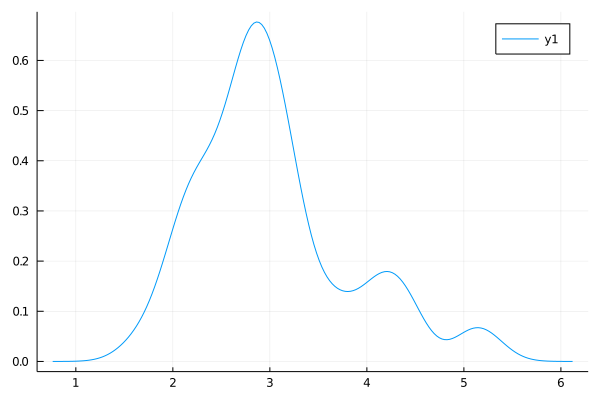

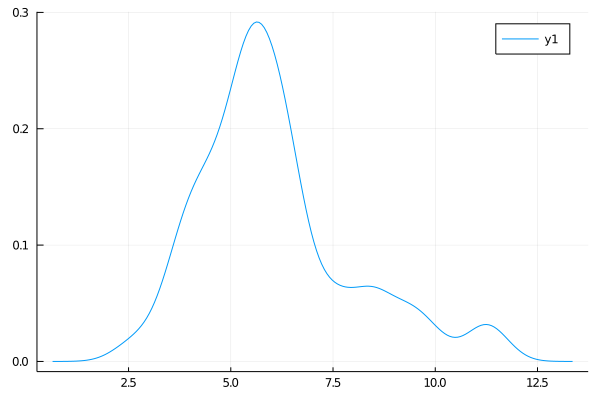

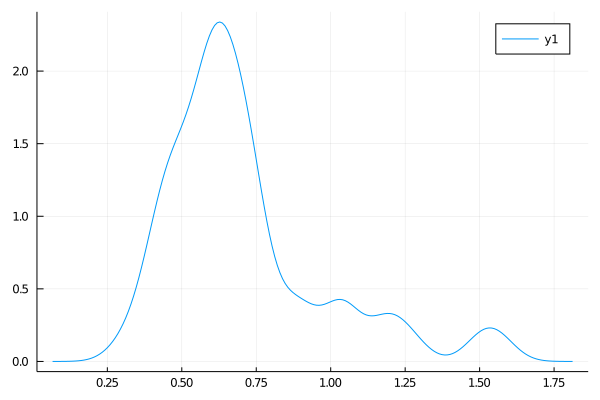

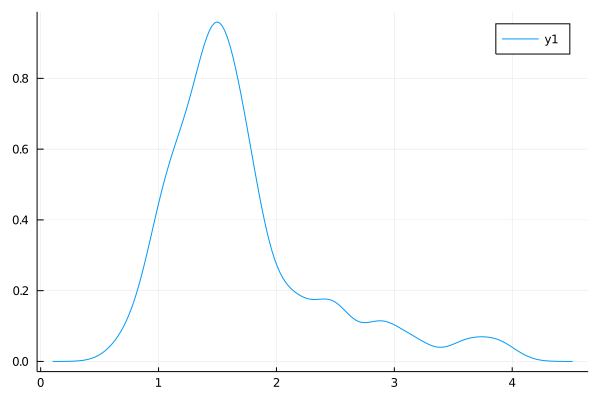

alpha: mean = 3.020862413265163 var = 0.62226850250882
delta: mean = 6.069350150688116 var = 3.6206615358956102
alpha_sd: mean = 0.7082745227560125 var = 0.07391940757650911
delta_sd: mean = 1.708240580080603 var = 0.4472021177607279


In [301]:
# Plots of empirical density for each parameter
d_alpha = density(sim_pars[:,1])
display(d_alpha)
d_delta = density(sim_pars[:,2])
display(d_delta)
println("alpha: mean = ", mean(sim_pars[:,1]), " var = ", var(sim_pars[:,1]))
println("delta: mean = ", mean(sim_pars[:,2]), " var = ", var(sim_pars[:,2]))

d_alpha_sd = density(sim_pars_sd[:,1])
display(d_alpha_sd)
d_delta_sd = density(sim_pars_sd[:,2])
display(d_delta_sd)
println("alpha_sd: mean = ", mean(sim_pars_sd[:,1]), " var = ", var(sim_pars_sd[:,1]))
println("delta_sd: mean = ", mean(sim_pars_sd[:,2]), " var = ", var(sim_pars_sd[:,2]))



In [305]:
# Simulate data for Q4

# True eq probs
function eq_probs(K)
    return exp.(LinRange(1,K,K)./2)./ sum(exp.(LinRange(1,K,K)./2))
end

# Individual terms in mixture log-likelihood
function mll_term(x, y, ep, bnp)
    
    # Check if term in log ever goes negative
    if (ep[x]' * (bnp[x][:,1].^y[1].*(1 .- bnp[x][:,1]).^(1 .- y[1]).*bnp[x][:,2].^y[2].*(1 .- bnp[x][:,2]).^(1 .- y[2])))[1] < 0
        println("neg in mll_term")
        println("    x: ", x)
        println("    y: ", y)
        println("    ep[x]: ", ep[x])
        println("    bnp[x]: ", bnp[x])
        return -Inf
    end
    
    return log.(ep[x]' * (bnp[x][:,1].^y[1].*(1 .- bnp[x][:,1]).^(1 .- y[1]).*bnp[x][:,2].^y[2].*(1 .- bnp[x][:,2]).^(1 .- y[2])))
end


# Log-likelihood (mixture)
function mix_log_lik(theta::AbstractVector{T}, x, y, ep_given::AbstractVector{T}) where T
    
    # Build bn_probs for each x
    bnp = [all_fp_logit_nk(1, theta), all_fp_logit_nk(2, theta)]
    
    # Check for negative BN probs
    for i in 1:length(bnp)
        if minimum(bnp[i]) < 0
            println("neg bnp: ", bnp)
            println("    at theta: ", theta)
        end
    end
    
    # Store eqs
    ep = []
    
    # x = 1
    if size(bnp[1],1) == 1
        # all weight on one eq
        push!(ep, [1])
    elseif size(bnp[1],1) == 3
        # use given weight split
        push!(ep,ep_given)
    else
        # finding a wrong number of eq (should not happen)
        println("weird bnp detected, x = 1, eq: ", size(bnp[1],1))
        push!(ep, eq_probs(size(bnp[1],1)))
    end
    
    # x = 2
    if size(bnp[2],1) == 1
        # all weight on one eq
        push!(ep, [1])
    elseif size(bnp[2],1) == 3
        # use given weight split
        push!(ep, ep_given)
    else
        # finding a wrong number of eq (should not happen)
        println("weird bnp detected, x = 2, eqs: ", size(bnp[2],1))
        push!(ep, eq_probs(size(bnp[2],1)))
    end
    
    # Check for negative eq probs
    for i in 1:length(ep)
        if minimum(ep[i]) < 0
            println("neg ep: ", ep)
            println("    at theta: ", theta)
        end
    end
    
    # Check if weird number of eqs
    if length(ep) != 2
        println("strange ep")
    end
    
    return sum([mll_term(x[i], y[i,:], ep, bnp) for i in 1:length(x)])
end



# Run Monte-Carlo with possible asymmetries per Q4
function asym_MC(theta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Store eqs. for each x type
    eqs = zeros(3,2,2)
    eqs[:,:,1] = all_fp_logit_nk(1, theta)
    eqs[:,:,2] = all_fp_logit_nk(2, theta)
    
    # Number of eqs (use that 3 in both cases)
    K = size(eqs,1)
    println("K: ", K)
    
    # Generate cutoff for choosing eq type
    eqprobs = LinRange(1,K,K)
    eqprobs = exp.(eqprobs./2)
    eqprobs = eqprobs./ sum(eqprobs)
#     println("eqprobs: ", eqprobs)
#     eq_cuts = cumsum(eqprobs)
#     sort!(eq_cuts)
#     println("eq_cuts: ", eq_cuts)
    
    # pmf over eq selection
    d = Categorical(eqprobs)
    
    # Initialize
    eq_draw = 0
#     eq = 0
    
#     eq_counts = zeros(K)
    
    # Probabilities
    p = zeros(S,T,2)
    for s in 1:S
        for t in 1:T
            # Draw eq selection
            draw = rand(d)
            
#             eq_counts[draw] += 1
            
            # add to probs list
            p[s,t,:] = eqs[draw,:,x[s,t]]
        end
    end
    
#     println("eq_counts check: ", sum(eq_counts))
#     println("eq_counts: ", eq_counts)
#     println("eq_dist: ", eq_counts ./sum(eq_counts))
    
    # Implied entries
    y = zeros(S,T,2)
    y = (theta[1] .* x .- theta[2].*p .+ ep) .> 0
    
    pars = zeros(S,5)
    pars_sd = zeros(S,5)
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
        mll(t) = -mix_log_lik(t[1:2], x[s,:], y[s,:,:], exp.(t[3:5])./sum(exp.(t[3:5])))
        
        # Max log-lik
        pars[s,:] = optimize(mll, [1.0, 1.0, 1.0, 1.0, 1.0], BFGS(), Optim.Options(show_trace = true, iterations = 20); autodiff = :forward).minimizer
        
        pars_sd[s,:] = sqrt.(abs.(diag(ForwardDiff.hessian(mll, pars[s,:]) \ I)))
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars, pars_sd
end

asim_pars, asim_pars_sd = asym_MC([3.0, 6.0], 50, 1000, 123456)


K: 3
Iter     Function value   Gradient norm 
     0     1.242205e+03     7.079745e+01
 * time: 0.00011897087097167969
     1     1.240376e+03     6.339621e+01
 * time: 0.040547847747802734
     2     1.175233e+03     8.087813e+01
 * time: 0.29560279846191406
     3     1.167784e+03     8.974182e+01
 * time: 0.5158419609069824
     4     1.159769e+03     2.207354e+01
 * time: 0.6017990112304688
     5     1.147924e+03     3.627664e+01
 * time: 0.6395139694213867
     6     1.144518e+03     2.514396e+01
 * time: 0.7128338813781738
     7     1.143333e+03     2.875117e+01
 * time: 1.2677209377288818
     8     1.138218e+03     6.247222e+01
 * time: 1.294611930847168
     9     1.137573e+03     4.878203e+00
 * time: 1.315431833267212
    10     1.135205e+03     6.868300e+00
 * time: 1.3908708095550537
    11     1.134835e+03     1.572011e+01
 * time: 1.5921528339385986
    12     1.134499e+03     7.618795e+00
 * time: 1.621837854385376
    13     1.134177e+03     3.190667e+00
 * time: 1.6

     1     1.219868e+03     3.228317e+01
 * time: 0.025303125381469727
     2     1.147917e+03     9.502736e+01
 * time: 0.0507349967956543
     3     1.124098e+03     9.209381e+01
 * time: 0.1734600067138672
     4     1.111672e+03     3.696492e+01
 * time: 0.2681241035461426
     5     1.102564e+03     3.692809e+01
 * time: 0.29769206047058105
     6     1.098584e+03     1.553113e+01
 * time: 0.3261079788208008
     7     1.096544e+03     3.325743e+01
 * time: 0.3907790184020996
     8     1.093789e+03     2.084695e+01
 * time: 0.4220249652862549
     9     1.092609e+03     4.079480e+01
 * time: 0.44628214836120605
    10     1.089809e+03     3.547322e+01
 * time: 0.507270097732544
    11     1.088974e+03     3.846185e+00
 * time: 0.5323841571807861
    12     1.088276e+03     4.348541e+00
 * time: 0.584097146987915
    13     1.087839e+03     8.865039e+00
 * time: 0.6182370185852051
    14     1.087762e+03     7.963633e-01
 * time: 0.6559269428253174
    15     1.087753e+03     2.49

     2     1.159104e+03     7.505573e+01
 * time: 0.4100220203399658
     3     1.149263e+03     7.704562e+01
 * time: 0.6138830184936523
     4     1.138075e+03     3.608796e+01
 * time: 0.7640411853790283
     5     1.129089e+03     2.939635e+01
 * time: 0.8535029888153076
     6     1.128048e+03     1.495078e+01
 * time: 0.8979990482330322
     7     1.122526e+03     4.153079e+01
 * time: 0.946835994720459
     8     1.119010e+03     2.172780e+01
 * time: 0.9786829948425293
     9     1.117769e+03     4.716669e+00
 * time: 1.0008080005645752
    10     1.117630e+03     3.660377e+00
 * time: 1.0302410125732422
    11     1.117493e+03     2.150387e+00
 * time: 1.0865671634674072
    12     1.116615e+03     1.357420e+01
 * time: 1.1255710124969482
    13     1.116589e+03     5.304917e+00
 * time: 1.2501389980316162
    14     1.116561e+03     8.136076e-01
 * time: 1.3164920806884766
    15     1.116554e+03     9.606678e-01
 * time: 1.3987371921539307
    16     1.116554e+03     3.48691

     2     1.178276e+03     8.239330e+01
 * time: 0.18014883995056152
     3     1.158813e+03     6.781487e+01
 * time: 0.453718900680542
     4     1.147774e+03     2.215467e+01
 * time: 0.5798289775848389
     5     1.143475e+03     2.667705e+01
 * time: 0.6648149490356445
     6     1.141238e+03     7.718168e+00
 * time: 0.7062540054321289
     7     1.140431e+03     1.148719e+01
 * time: 0.7390389442443848
     8     1.139991e+03     2.222780e+00
 * time: 0.7799868583679199
     9     1.138387e+03     4.787965e+00
 * time: 0.8466529846191406
weird bnp detected, x = 1, eq: 2
    10     1.138141e+03     6.179019e+00
 * time: 0.9273369312286377
    11     1.137807e+03     6.886970e+00
 * time: 1.002614974975586
    12     1.137526e+03     6.382931e+00
 * time: 1.0657098293304443
    13     1.137248e+03     1.909557e+00
 * time: 1.1694259643554688
    14     1.137226e+03     1.029874e+00
 * time: 1.233872890472412
    15     1.137224e+03     2.833356e-01
 * time: 1.4035530090332031
   

     2     1.168526e+03     9.907653e+01
 * time: 0.07097196578979492
     3     1.133554e+03     7.667493e+01
 * time: 0.21930909156799316
     4     1.125654e+03     2.729342e+01
 * time: 0.3083178997039795
     5     1.117609e+03     4.410938e+01
 * time: 0.3356800079345703
     6     1.113864e+03     1.894018e+01
 * time: 0.38007402420043945
     7     1.110574e+03     7.776199e+00
 * time: 0.4260590076446533
     8     1.109824e+03     6.447184e+00
 * time: 0.4575328826904297
     9     1.108815e+03     2.066395e+01
 * time: 0.5225419998168945
    10     1.106666e+03     9.899190e+00
 * time: 0.5741629600524902
    11     1.106101e+03     1.054351e+01
 * time: 0.6359860897064209
    12     1.105581e+03     9.344928e+00
 * time: 0.673011064529419
    13     1.104661e+03     5.348672e+00
 * time: 0.7259039878845215
    14     1.104227e+03     3.064775e+00
 * time: 0.7651979923248291
    15     1.104212e+03     1.063525e+00
 * time: 0.8045139312744141
    16     1.104207e+03     2.31

     5     1.135947e+03     2.564811e+01
 * time: 0.3003058433532715
     6     1.129177e+03     2.800189e+01
 * time: 0.365947961807251
     7     1.125548e+03     2.171371e+01
 * time: 0.39775991439819336
     8     1.124589e+03     2.342934e+01
 * time: 0.5797908306121826
     9     1.122520e+03     2.419682e+01
 * time: 0.6066620349884033
    10     1.117539e+03     1.954261e+01
 * time: 0.6439299583435059
    11     1.117236e+03     7.543091e+00
 * time: 0.7031278610229492
    12     1.115658e+03     1.793200e+01
 * time: 0.7470459938049316
    13     1.115252e+03     2.034415e+01
 * time: 0.7751169204711914
    14     1.114690e+03     4.652911e+00
 * time: 0.7995588779449463
    15     1.114591e+03     3.811756e+00
 * time: 0.8449969291687012
    16     1.114419e+03     5.186433e+00
 * time: 0.8807249069213867
    17     1.114392e+03     7.503984e-01
 * time: 0.9061548709869385
    18     1.114391e+03     8.483575e-02
 * time: 0.9390568733215332
    19     1.114391e+03     3.2381

     5     1.142251e+03     3.525282e+01
 * time: 0.28304100036621094
     6     1.139941e+03     3.558895e+01
 * time: 0.326948881149292
     7     1.131139e+03     2.772370e+01
 * time: 0.41101694107055664
weird bnp detected, x = 1, eq: 2
     8     1.131072e+03     2.797189e+01
 * time: 0.5593349933624268
     9     1.128308e+03     6.014803e+01
 * time: 0.5861859321594238
    10     1.124071e+03     7.206109e+00
 * time: 0.6304209232330322
    11     1.120720e+03     3.088880e+01
 * time: 0.6727778911590576
    12     1.119314e+03     1.875125e+01
 * time: 0.751101016998291
    13     1.118479e+03     7.550633e+00
 * time: 0.7786688804626465
    14     1.118100e+03     4.529603e+00
 * time: 0.8752138614654541
    15     1.118001e+03     4.673685e-01
 * time: 0.8941128253936768
    16     1.118000e+03     1.839405e-01
 * time: 0.9258108139038086
    17     1.117242e+03     3.862822e+01
 * time: 0.981367826461792
    18     1.116941e+03     3.283615e+01
 * time: 1.0159499645233154
  

     5     1.122222e+03     3.973983e+01
 * time: 0.33388710021972656
     6     1.119468e+03     1.785778e+01
 * time: 0.3639070987701416
     7     1.117392e+03     1.539069e+01
 * time: 0.38785600662231445
     8     1.113386e+03     1.400804e+01
 * time: 0.5730991363525391
     9     1.113085e+03     2.519869e+01
 * time: 0.5915560722351074
    10     1.112237e+03     1.350501e+01
 * time: 0.62518310546875
    11     1.111416e+03     2.185654e+01
 * time: 0.6666510105133057
    12     1.111049e+03     2.127368e+01
 * time: 0.6960010528564453
    13     1.110447e+03     3.429833e+00
 * time: 0.7396950721740723
    14     1.110168e+03     4.751272e+00
 * time: 0.7920901775360107
    15     1.109978e+03     2.728120e+00
 * time: 0.8382291793823242
    16     1.109857e+03     7.210730e+00
 * time: 0.8968071937561035
    17     1.109810e+03     6.575014e-01
 * time: 0.9239621162414551
    18     1.109806e+03     1.847694e-01
 * time: 0.9757602214813232
    19     1.109805e+03     3.8588

    10     1.141733e+03     7.700708e+00
 * time: 0.7220869064331055
    11     1.139124e+03     7.795217e+00
 * time: 0.7666468620300293
    12     1.138955e+03     1.233166e+01
 * time: 0.8330409526824951
    13     1.138743e+03     1.978670e+01
 * time: 0.8728668689727783
    14     1.138540e+03     8.834386e+00
 * time: 0.9156479835510254
    15     1.138064e+03     5.976089e+00
 * time: 0.9488039016723633
    16     1.138032e+03     1.994237e+00
 * time: 0.9956769943237305
    17     1.138031e+03     7.179720e-02
 * time: 1.034290075302124
    18     1.138030e+03     8.217306e-03
 * time: 1.0664188861846924
    19     1.138030e+03     6.072686e-04
 * time: 1.1184189319610596
    20     1.138030e+03     1.393522e-04
 * time: 1.1709160804748535
Simulation 41 complete:
    par: [2.8644178617286014, 5.793610506643246, 1.5269429335996967, 1.0903213453303668, 0.3827357210701613]
Iter     Function value   Gradient norm 
     0     1.236963e+03     6.202181e+01
 * time: 7.510185241699219e

    12     1.127042e+03     2.497368e+01
 * time: 0.7108781337738037
    13     1.126210e+03     4.058648e+01
 * time: 0.7733759880065918
    14     1.123484e+03     1.245604e+01
 * time: 0.8180930614471436
    15     1.122620e+03     8.459050e+00
 * time: 0.852910041809082
    16     1.122376e+03     3.615206e+00
 * time: 0.95147705078125
    17     1.122234e+03     1.024433e+00
 * time: 0.9977471828460693
    18     1.122198e+03     3.178590e-01
 * time: 1.062852144241333
    19     1.122197e+03     3.736077e-01
 * time: 1.1079649925231934
    20     1.122197e+03     1.067188e-02
 * time: 1.140254020690918
Simulation 46 complete:
    par: [3.0320778973519187, 6.075266752867741, 1.544071994207764, 1.2165821169230064, 0.23934588886904873]
Iter     Function value   Gradient norm 
     0     1.243615e+03     7.667476e+01
 * time: 6.794929504394531e-5
     1     1.242613e+03     6.782438e+01
 * time: 0.05357789993286133
     2     1.172358e+03     6.091498e+01
 * time: 0.10282492637634277

([2.9043914215015265 5.843284089510395 … 0.9281385592049025 0.5552511159077961; 2.9546658608453518 5.916432401262124 … 0.7938550683214393 0.5614437461986895; … ; 3.2027967261877475 6.347003112836722 … 1.2423121491253615 0.2773303725636074; 3.126865810071151 6.274655181131606 … 1.021428808864026 0.4767015292254054], [0.17278179340202293 0.2591725268403712 … 1.157737894324864e6 1.157737894324705e6; 0.1763832253199947 0.2645054829712557 … 834956.0737569539 834956.0737570268; … ; 0.222783492044007 0.36998554534842554 … 2.065132531922191e6 2.0651325319223169e6; 0.24578397317787407 0.4265557739851671 … 3.7514995449196743e6 3.751499544919711e6])

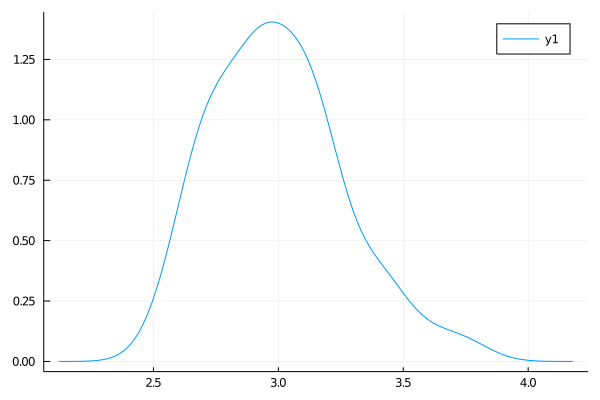

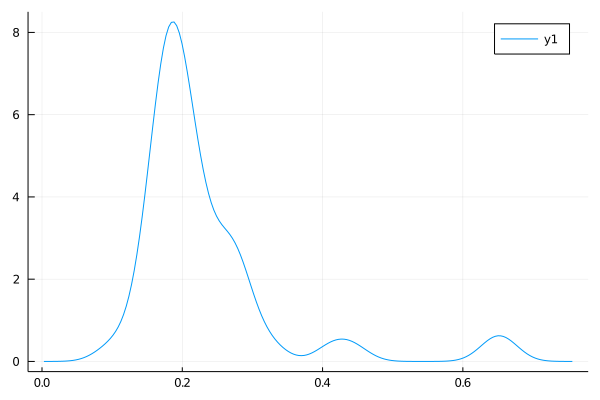

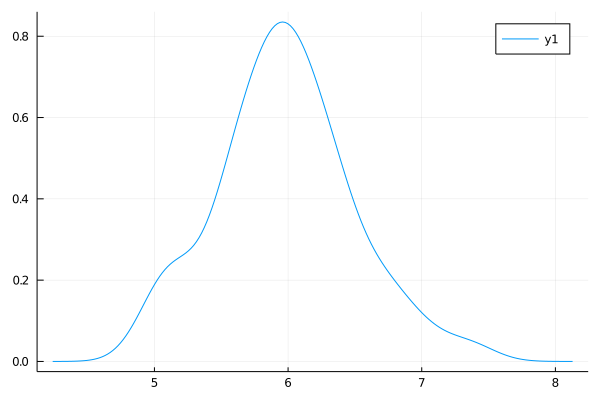

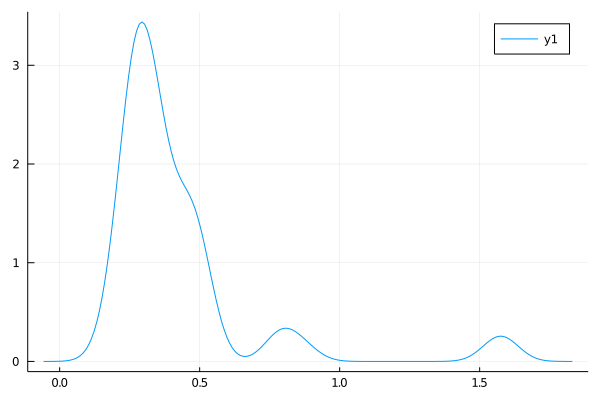

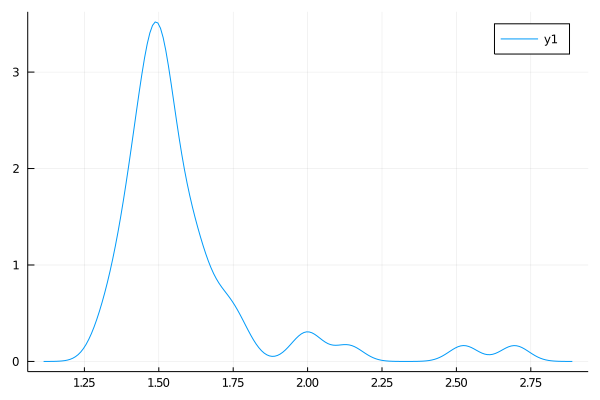

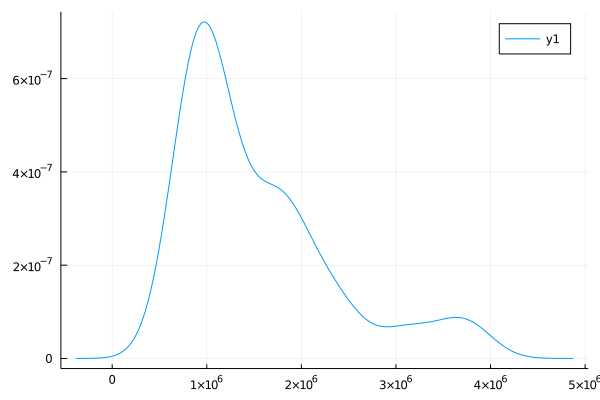

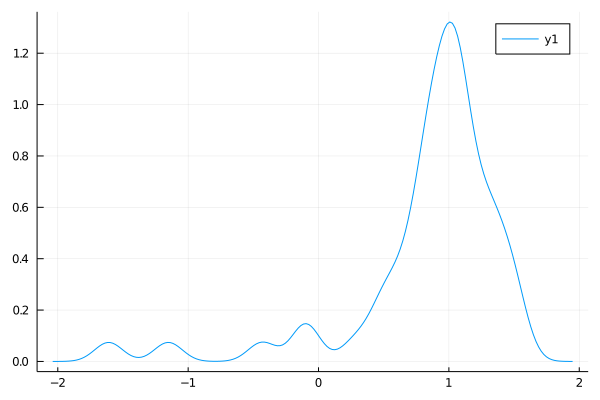

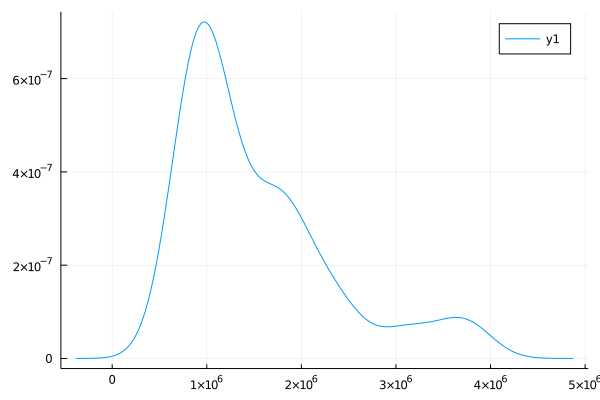

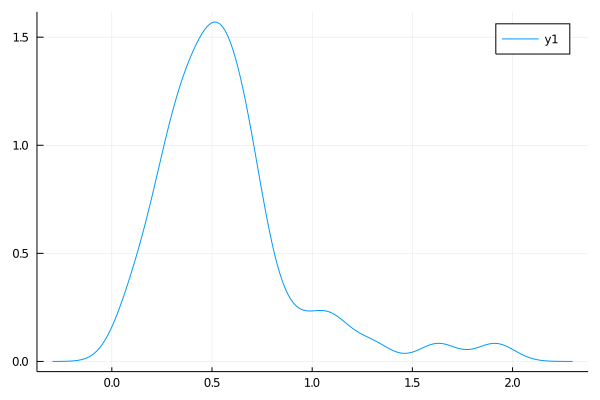

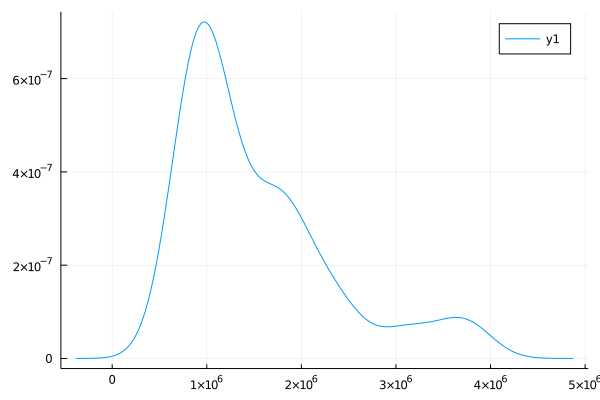

asim_pars[:,1]: mean = 2.998420756584455 var = 0.06934324105662393
asim_pars_sd[:,1]: mean = 0.23176946892809988 var = 0.011424154481619308
asim_pars[:,2]: mean = 5.979846143440452 var = 0.25579934747527233
asim_pars_sd[:,2]: mean = 0.41756704777475 var = 0.07763159421937059
asim_pars[:,3]: mean = 1.5902823433643192 var = 0.0712829981887585
asim_pars_sd[:,3]: mean = 1.5335988865182572e6 var = 6.638143384572704e11
asim_pars[:,4]: mean = 0.8334247575945639 var = 0.3690680920680603
asim_pars_sd[:,4]: mean = 1.5335988865163454e6 var = 6.63814338458487e11
asim_pars[:,5]: mean = 0.5762928990404077 var = 0.12558415742831325
asim_pars_sd[:,5]: mean = 1.5335988865182546e6 var = 6.638143384572681e11
weights: [0.5458791850050393 0.2560928547561904 0.19802796023877012]


In [306]:
# Plots of empirical density for each parameter

for i in 1:size(asim_pars,2)
    ad_theta = density(asim_pars[:,i])
    display(ad_theta)
    println("asim_pars[:," , i,"]: mean = ", mean(asim_pars[:,i]), " var = ", var(asim_pars[:,i]))
    
    ad_theta_sd = density(asim_pars_sd[:,i])
    display(ad_theta_sd)
    println("asim_pars_sd[:," , i,"]: mean = ", mean(asim_pars_sd[:,i]), " var = ", var(asim_pars_sd[:,i]))
end

println("weights: ", exp.(mean(asim_pars[:,3:5], dims=1))./sum(exp.(mean(asim_pars[:,3:5], dims=1))))

In [308]:
# Load data
df = DataFrame()
df = CSV.read("psetTwo.csv", DataFrame)

# Mileage
mileage = df.milage
N = length(mileage)

# Find replacement periods
d_rep = [0; (mileage[2:N] - mileage[1:N-1]) .< 0]

5000-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

In [309]:
# Discretize the domain (equispacing)
# function disc_domain(data, K)
#     println("equispace used")
#     M = maximum(data)
#     m = minimum(data)
#     return LinRange(m,M,K)
# end

# Discretize domain (equal mass in each bin)
function disc_domain(data, K)
    
    println("equimass used")
    
    # Sort data
    data_sorted = sort(data)
    
    # Initialize
    disc = zeros(K)
    
    # Chunk up so each bin has same number of entries
    for k in 1:K
        disc[k] = data_sorted[Int(floor(k*N/K))]
    end
    
    return disc
end

# Map value to its chunk
function to_chunk(vs, chunks)
    
    # Initialize
    its = zeros(length(vs))
    
    # Find chunk for each v
    for j in 1:length(vs)
        it = 1
        
        # Continue until value larger than lower end of chunk
        while vs[j] > chunks[it] && it < length(chunks)
            it += 1
        end
        
        its[j] = it
    end
    
    return Int64.(its)
end

# Create transition matrices
function trans_mats(x, d, K)
    
    # Get discretized domain
    disc = disc_domain(x, K)
    
    # For replacement
#     rep = zeros(K,K)
    
    # For no replacement
    no_rep = zeros(K,K)
    
    # Get chunks
    chunk_map = to_chunk(x, disc)
    
    # Fix this for single matrix
#     for i in 2:length(m)
#         if d[i] > 0
#             rep[chunk_map[i-1], chunk_map[i]] += 1
#         else
#             no_rep[chunk_map[i-1], chunk_map[i]] += 1
#         end
#     end
    
    # Add mass in each transition
    for i in 2:length(x)
        no_rep[chunk_map[i-1], chunk_map[i]] += 1
    end
    
    # If no entries in row, assume full mass on diag?
    for k in 1:K
#         if sum(rep[k,:]) == 0
#             rep[k,1] = 1
#         end
        
        if sum(no_rep[k,:]) == 0
            no_rep[k,k] = 1
        end
        
    end
    
    # Normalize
#     rep = rep.*(1 ./max.(sum(rep,dims=2), 1.0))
    no_rep = no_rep.*(1 ./sum(no_rep,dims=2))
    
    return no_rep #, rep
end

# Utility (shock not included)
function u(x, d, theta)
    if d == 0
        return -theta[1].*x - theta[2].*(x./100).^2
    else
        return -theta[3].*ones(length(x))
    end
end

# Jacobian of u wrt theta
function uj(x, d, theta)
    if d == 0
        return hcat(-x, -(x./100).^2, zeros(length(x)))
    else
        return hcat(zeros(length(x)), zeros(length(x)), -ones(length(x)))
    end
end


# For fixed point of EV
function Gamma(EV, P, X, beta, theta)
    return P*log.(exp.(u(X,0,theta) .+ beta.*EV) .+ exp.(u(X,1,theta) .+ beta.*EV[1]))
end

# Conditional choice probs
# (sum to 1 when considering exactly exhaustive choices)
# Default to just using X, EV
function ch_probs(EV, X, beta, theta, x_inds = [i for i in 1:length(X)])
    return exp.(u(X[x_inds],0,theta) .+ beta.*EV[x_inds] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds]))./(exp.(u(X[x_inds],0,theta) .+ beta.*EV[x_inds] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds])) .+ exp.(u(X[x_inds],1,theta) .+ beta.*EV[1] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds])))
end

# Jacobian of Gamma wrt EV (K x K)
function Gamma_jac_EV(EV, P, X, beta, theta)
    return P*(diagm(ch_probs(EV, X, beta, theta)) .* beta .+ (1 .- ch_probs(EV, X, beta, theta)) .* beta .* [i == 1 for j in 1:length(EV), i in 1:length(EV)])
end

# Jacobian of Gamma wrt theta (K x 3)
function Gamma_jac_theta(EV, P, X, beta, theta)
    return P*((exp.(u(X,0,theta) .+ beta.*EV .- maximum(u(X,0,theta) .+ beta.*EV))  .* uj(X,0,theta) .+ exp.(u(X,1,theta) .+ beta.*EV[1] .- maximum(u(X,0,theta) .+ beta.*EV)) .* uj(X,1,theta))./(exp.(u(X,0,theta) .+ beta.*EV .- maximum(u(X,0,theta) .+ beta.*EV)) .+ exp.(u(X,1,theta) .+ beta.*EV[1] .- maximum(u(X,0,theta) .+ beta.*EV))))
end

# Contraction mapping to solve EV
function contract_EV(EV, P, X, beta, theta, maxiter = 1000, tol = 1e-5)
    
    # Initialize
    it = 1
    diff = Inf
    EVnew = zeros(length(EV))
    
    while it < maxiter && diff > tol
        
        # Find new
        EVnew = Gamma(EV, P, X, beta, theta)
        
        # Find diff
        diff = maximum(abs.(EVnew - EV))
        
        # Update
        it += 1
        EV = EVnew
    end
    
    # Status updates
#     println("Contraction done")
#     println("    it: ", it)
#     println("    diff: ", diff)
#     println("    EV: ", EV)
    
    return EV
end

# Newton-Kantorovich to solve EV
function nk_EV(EV, P, X, beta, theta, maxiter = 1000, tol = 1e-14)
    
    # Initialize
    it = 1
    diff = Inf
    EVnew = zeros(length(EV))
    
    while it < maxiter && diff > tol
        
        # Get new
        EVnew = EV - (I - Gamma_jac_EV(EV, P, X, beta, theta)) \ (EV - Gamma(EV, P, X, beta, theta))
        
        # Get diff
        diff = maximum(abs.(EVnew - EV))
        
        # Update
        it += 1
        EV = EVnew
    end
    
    # Status updates
#     println("Newton-Kantorovich done")
#     println("    it: ", it)
#     println("    diff: ", diff)
#     println("    EV: ", EV)
    
    return EV
end

# Combine contraction and Newton-Kantorovich
function poly_algo(P, X, beta, theta,
        maxiter_c = 1000, tol_c = 1e-5,
        maxiter_nk = 1000, tol_nk = 1e-16
    )
    
    # Initialize
    EV = zeros(length(X))
    
    # Contract
    EV = contract_EV(EV, P, X, beta, theta, maxiter_c, tol_c)
    
    # NK
    EV = nk_EV(EV, P, X, beta, theta, maxiter_nk, tol_nk)
    
    return EV
end

# Log-likelihood
function log_lik(theta, beta, d, X, x_inds)
#     return d'*log.(1 .- pr(theta, beta, P, X, x_inds)) .+ (1 .- d')*log.(pr(theta, beta, P, X, x_inds))
    return (d'*log.(1 .- ch_probs(poly_algo(P, X, beta, theta), X, beta, theta, x_inds)) .+ (1 .- d')*log.(ch_probs(poly_algo(P, X, beta, theta), X, beta, theta, x_inds)))[1]
end

# Log-likelihood (EV known)
# function log_lik_simple(theta, beta, d, X, EV, x_inds)
#     return return d'*log.(1 .- ch_probs(EV, X, beta, theta, x_inds)) .+ (1 .- d')*log.(ch_probs(EV, X, beta, theta, x_inds))
# end

# Expression inside exp in jacobian of probs
# Note: no - max(V) stabilization here
function inside_exp(theta, beta, X, x_inds)
    return u(X[x_inds],1,theta) .+ beta.* poly_algo(P, X, beta, theta)[1] .- u(X[x_inds],0,theta) .- beta.*poly_algo(P, X, beta, theta)[x_inds]
end

# Jacobian of expression inside exp
function inside_exp_jac(theta, beta, X, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .*EV_jac(poly_algo(P, X, beta, theta), P, X, beta, theta)[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EV_jac(poly_algo(P, X, beta, theta), P, X, beta, theta)[x_inds,:]
end

# choice probs (used for AD testing)
function pr(theta, beta, P, X, x_inds = [i for i in 1:length(X)])
#     println("AAA")
    return exp(-maximum(inside_exp(theta, beta, X, x_inds))) ./ (exp(-maximum(inside_exp(theta, beta, X, x_inds)))  .+ exp.(inside_exp(theta, beta, X, x_inds) .- maximum(inside_exp(theta, beta, X, x_inds))))
end

# Take advantage of EV and EVjac known
function simple_inside_exp(theta, beta, X, EV, EVjac, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .* EVjac[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EVjac[x_inds, :]
end

# Take advantage of EV and EVjac known
function simple_inside_exp_jac(theta, beta, X, EV, EVjac, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .*EVjac[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EVjac[x_inds,:]
end

# Jacobian of choice probs wrt theta (EV and EVjac known)
function pr_jac_simple(theta, beta, X, EV, EVjac, x_inds = [i for i in 1:length(X)])
    return -exp.(simple_inside_exp(theta, beta, X, EV, EVjac, x_inds)) ./ ((1 .+ exp.(simple_inside_exp(theta, beta, X, EV, EVjac, x_inds))).^2) .* simple_inside_exp_jac(theta, beta, X, EV, EVjac, x_inds)
end

function pr_jac(theta, beta, X, x_inds = [i for i in 1:length(X)])
    return -exp.(inside_exp(theta, beta, X, x_inds)) ./ ((1 .+ exp.(inside_exp(theta, beta, X, x_inds))).^2) .* inside_exp_jac(theta, beta, X, x_inds)
end

# Jacobian of EV wrt theta
function EV_jac(EV, P, X, beta, theta)
    return (I - Gamma_jac_EV(EV, P, X, beta, theta)) \ Gamma_jac_theta(EV, P, X, beta, theta)
end

# Jacobian of log likelihood (wrt theta) (EV, EVjac known)
function log_lik_jac_simple(theta, beta, d, X, EV, EVjac, P, x_inds)
    return (-d.*(1 ./(1 .- ch_probs(EV, X, beta, theta, x_inds))) .+ (1 .- d).*(1 ./ch_probs(EV, X, beta, theta, x_inds)))' * pr_jac(theta, beta, X, EV, EVjac, x_inds)
end

# Jacobian of log likelihood (wrt theta)
function log_lik_jac(theta, beta, d, X, P, x_inds)
    return ((-d.*(1 ./(1 .- pr(theta, beta, P, X, x_inds))) .+ (1 .- d).*(1 ./pr(theta, beta, P, X, x_inds)))' * pr_jac(theta, beta, X, x_inds))[1,:]
end

# Jacobian of log likelihood (wrt theta) for optimizing
# function log_lik_jac_op(storage, z)
#     storage = log_lik_jac(z, beta, d, X, P, x_inds)
# end

function solve_theta(beta, d, x, K, theta_init = [0.01, 0.01, 0.01])
    P = trans_mats(x, d, K)
#     println("P: ", P)
    X = disc_domain(x, K)
#     println("X: ", X)
    x_inds = to_chunk(x,X)
#     println("x_inds: ", x_inds)
    
    ll(z) = -log_lik(z, beta, d, X, x_inds)
    
#     llj(z) =  -log_lik_jac(z, beta, d, X, P, x_inds)
    
    function llj!(storage, z)
        storage .= -log_lik_jac(z, beta, d, X, P, x_inds)
    end
    
#     return optimize(ll, theta_init, NelderMead())
#     return optimize(ll, theta_init, LBFGS(); autodiff = :forward)
    return optimize(ll, llj!, theta_init, BFGS()) #, inplace = false)
end


solve_theta (generic function with 2 methods)

In [310]:
# Random.seed!(1234)
K = 5
P = trans_mats(mileage, d_rep, K)
X = disc_domain(mileage, K)
D = rand(K) .> 1/2
beta = 0.999
theta = [0.01,0.02,0.03]

x = mileage
x_inds = to_chunk(x, X)
d = d_rep

EV = zeros(K)

# contract_EV(EV, P, X, beta, theta)
# nk_EV(EV, P, X, beta, theta)

EV = poly_algo(P, X, beta, theta)
EVjac = EV_jac(EV, P, X, beta, theta)
# EV[x_ind]

# println("ch: ", ch_probs(EV, X, beta, theta))

# println("pr: ", pr(theta, beta, P, X))
# println("ch - pr: ", ch_probs(EV, X, beta, theta) - pr(theta, beta, P, X))

# d = [1.0, 0.0, 1.0, 0.0, 0.0]
# x = [X[1], X[2], X[1], X[2], X[3]]

# uj(X, 0, theta)
# uj(X, 1, theta)
# Gamma_jac_theta(EV, P, X, beta, theta)
# EV_jac(EV, P, X, beta, theta)

# log_lik(theta, beta, d, X, EV, x_inds)




# Check Jacobians against AD here

# u
# println("u jac: ", uj(x, 0, theta))
u_forAD0(z) = u(x, 0, z)
ForwardDiff.jacobian(u_forAD0, theta) - uj(x, 0, theta)

# println("u jac: ", uj(x, 0, theta))
u_forAD1(z) = u(x, 1, z)
ForwardDiff.jacobian(u_forAD1, theta) - uj(x, 1, theta)

# Gamma EV
# println("Gamma jac EV: ", Gamma_jac_EV(EV, P, X, beta, theta))
GEV_forAD(z) = Gamma(z, P, X, beta, theta)
ForwardDiff.jacobian(GEV_forAD, EV) - Gamma_jac_EV(EV, P, X, beta, theta)

# Gamma theta
# println("Gamma jac theta: ", Gamma_jac_theta(EV, P, X, beta, theta))
# Gtheta_forAD(z) = Gamma(EV, P, X, beta, z)
# ForwardDiff.jacobian(Gtheta_forAD, theta) - Gamma_jac_theta(EV, P, X, beta, theta)

# EV - seems to be within error margin? (2e-11)
# Actually probably pretty good since this is the jacobian of an FP algo
# println("EV jac theta: ", EV_jac(EV, P, X, beta, theta))
EV_forAD(z) = poly_algo(P, X, beta, z)
ForwardDiff.jacobian(EV_forAD, theta) - EVjac #EV_jac(EV, P, X, beta, theta)


# inside_exp_jac(theta, beta, X, x_inds)


# inside_exp
# println("ie jac: ", inside_exp_jac(theta, beta, X, x_inds))
# ie_forAD(z) = inside_exp(z, beta, X, x_inds)
# ForwardDiff.jacobian(ie_forAD, theta) - inside_exp_jac(theta, beta, X, x_inds)

# p
# -> ch_probs does not take into account how theta affects EV
# println("pr jac: ", pr_jac(theta, beta, X))
# pr_forAD(z) = pr(z, beta, P, X)
# ForwardDiff.jacobian(pr_forAD, theta) - pr_jac(theta, beta, X)

# log lik (BROKEN BECAUSE OF PR BROKEN)
# println("log lik jac: ", size(log_lik_jac(theta, beta, d, X, P, x_inds)))
# ll_forAD(z) = log_lik(z, beta, d, X, x_inds)
# ForwardDiff.gradient(ll_forAD, theta) - log_lik_jac(theta, beta, d, X, P, x_inds)

# log_lik(theta, beta, d, X, x_inds)

# NEED TO CHECK FOR OVERFLOW
# Solve for theta
theta_init = [0.001, 0.01, 0.01]
soln = solve_theta(beta, d, x, K, theta_init)

equimass used
equimass used
equimass used
equimass used


 * Status: success

 * Candidate solution
    Final objective value:     3.180850e+03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.73e-18 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-16 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.42e+05 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    4
    f(x) calls:    320
    ∇f(x) calls:   320


In [311]:
soln.minimizer

3-element Array{Float64,1}:
 -0.0009379236102099465
  0.009966453941326345
  0.0100117408828595